# Описание этапа

На данном этапе вам необходимо:

* Сформировать обучающую выборку

* Спроектировать схему валидации с учетом специфики задачи

* Обосновать выбор способа валидации

# Данный ноутбук разбит на несколько частей:
1. Проектирование схемы валидации
2. Новый способ получения эмбеддингов для изображений
3. Выбор метрик
4. Обнаружение и описание проблем с инференсом во время экспериментов с моделями
5. Уменьшение датасета для проведения некоторых экспериментов
6. Apriopi

# 1. Проектирование схемы валидации

Прежде, чем выбирать метрики качества для модели рекомендательных систем, необходимо грамотно выбрать схему валидации, учитывая специфику задачии и данных.

#### Существующие подходы для разбиения данных:

1. Случайное разбиение:
* Leave one out
 * Для test оставляем одно случайное взаимодействие
* Leave P out
 * Для test оставляем P случайных взаимодействий
2. Хронологическое разбиение:
* Оставляем в test только последние взаимодействия по пользователям или объектам
 * Last one out
 * Last P out
3. Разбиение по времени:
* Оставляем в test только конкретный временной промежуток, например последний день или последняя неделя
---
При генерации надо учитывать так же cold start и warm start сценарии

## Анализ данных для выбора метода валидации

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

Mounted at /content/drive


In [2]:
df = pd.read_parquet('clickstream.parquet')

In [ ]:
df.head()

In [4]:
# Всего пользователей
df['wbuser_id'].nunique()

3926535

In [5]:
# Пользователей в 10 день
df[df['day'] == 10]['wbuser_id'].nunique()

2455930

In [6]:
# Товаров в 10 день
df[df['day'] == 10]['nm_id'].nunique()

280200

In [7]:
# Пользователей в 11 день
df[df['day'] == 11]['wbuser_id'].nunique()

2326375

In [8]:
# Пользователей в 11 день
df[df['day'] == 11]['nm_id'].nunique()

278328

In [9]:
users_day10 = set(df[df['day'] == 10]['wbuser_id'])

users_day11 = set(df[df['day'] == 11]['wbuser_id'])

unique_day11_users = users_day11 - users_day10

count_unique_day11 = len(unique_day11_users)

print(f"Количество пользователей, которые смотрели товары в 11 день и не смотрели в 10 день: {count_unique_day11}")

Количество пользователей, которые смотрели товары в 11 день и не смотрели в 10 день: 1470605


In [10]:
# Посчитаем количество взаимодействий для каждого пользователя
user_counts = df['wbuser_id'].value_counts()

In [11]:
# Посчитаем у скольких пользователей меньше 3 взаимодействий
min_val = 2
filtered_values = user_counts[user_counts <= min_val]

In [12]:
# Количество пользователей во всем датасете у кого меньше 3 взаимодействий
len(filtered_values)

1467284

In [13]:
# Составим датасет только для взаимодействий в 11 день
day_11 = df[df['day'] == 11]

In [14]:
# Посчитаем количество взаимодействий пользователей в 11 день
user_counts_11 = day_11['wbuser_id'].value_counts()

In [15]:
# Количество пользователей у кого 11 числа меньше 3 взаимодействий
min_val = 2
filtered_values1 = user_counts_11[user_counts_11 <= min_val]
print(len(filtered_values1))

960297


In [16]:
# Количество пользователей с 3 и с более чем 3 взаимодействиями в 11 день
min_val = 3
filtered_values2 = user_counts_11[user_counts_11 == min_val]
filtered_values3 = user_counts_11[user_counts_11 > min_val]

In [17]:
len(filtered_values2), len(filtered_values3)

(183797, 1182281)

In [18]:
# Посмотрим, сколько пользователей из общего датасета с менее, чем 3 взаимодействиями относятся к 11 дню и не относятся к 10

# Фильтруем `filtered_values1` по наличию в `users_day11`
common_users_series = filtered_values1[filtered_values1.index.isin(unique_day11_users)]

# Количество общих пользователей
num_common_users = common_users_series.count()

print(f"Количество пользователей у которых меньше: {num_common_users}")

Количество пользователей у которых меньше: 663562


In [19]:
# Считаем количество взаимодействий каждого пользователя
user_interactions = df.groupby('wbuser_id').size()

# Выбираем пользователей, у которых меньше 3 взаимодействий
users_less_than_3 = user_interactions[user_interactions < 3].index

# Фильтруем исходный DataFrame только с пользователями, у которых <3 взаимодействия
filtered_df = df[df['wbuser_id'].isin(users_less_than_3)]

# Пользователи, взаимодействия которых только в 11-й день
only_day_11_users = filtered_df.groupby('wbuser_id')['day'].unique()
only_day_11_users = [user for user, days in only_day_11_users.items() if set(days) == {11}]

# Количество таких пользователей
count_only_day_11_users = len(only_day_11_users)

# Пользователи, которые взаимодействовали и в 10-й, и в 11-й день
both_days_users = filtered_df.groupby('wbuser_id')['day'].unique()
both_days_users = [user for user, days in both_days_users.items() if set(days) == {10, 11}]

# Количество таких пользователей
count_both_days_users = len(both_days_users)

# Результаты
print("Количество пользователей, <3 взаимодействий, только в 11 день:", count_only_day_11_users)
print("Количество пользователей, <3 взаимодействий, в 10 и 11 дни:", count_both_days_users)

Количество пользователей, <3 взаимодействий, только в 11 день: 663562
Количество пользователей, <3 взаимодействий, в 10 и 11 дни: 50991


In [20]:
only_day_10_users = filtered_df.groupby('wbuser_id')['day'].unique()
only_day_10_users = [user for user, days in only_day_10_users.items() if set(days) == {10}]

# Количество таких пользователей
count_only_day_10_users = len(only_day_10_users)

print("Количество пользователей, <3 взаимодействий, только в 10 день:", count_only_day_10_users)

Количество пользователей, <3 взаимодействий, только в 10 день: 752731


#### Теперь, когда у нас есть больше информации о специфике датасета, можно выделить некоторые ключевые особенности:
* Данные собраны всего за два дня
* 1.5 миллиона пользователей имеют меньше трех взаимодействий
* За 11 день появилось 1,5 миллиона пользователей, которые не взаимодействовали в предыдущий день, и всего 800 тысяч пользователей взаимодействовали оба дня
* Есть 660 тысяч пользователей, которые взаимодействовали в 11 день менее трех раз и все эти пользователи - новые пользователи относительно 10 дня. 50 тысяч пользователей взаимодействовали менее 3 раз по 1 взаимодействию каждый день

#### Выводы:
* Разделять по времени, например, оставивлять последние 6 часов на тест - не совсем корректный подход. Навряд ли при такой валидации можно будет сказать, что полученная модель хорошо или плохо предсказывает поведение пользователей в течение всего дня. К тому же при таком разбиении в подавляющем количестве пользователи будут холодными, что дополнительно помешает понять как модель справляется с рекомендациями для пользователей, которые уже совершали действия
* Так как для нас важна хронология событий, оставлять для теста случайные взаимодействия тоже плохой подход. Нужно оставлять для теста последние события
* Если забрать последние события у всех пользователей, то модели будет не на чем учиться, так как, например, забрав у всех пользователей, у которых было 3 взаимодействия, 2 последних, модель не сможет научиться определять для такой группы пользователей следующие взаимодействия

# Выбранная схема создания обучающей, валидационной и тестовых выборок

Схематически выбранный метод представлен на рисунке:

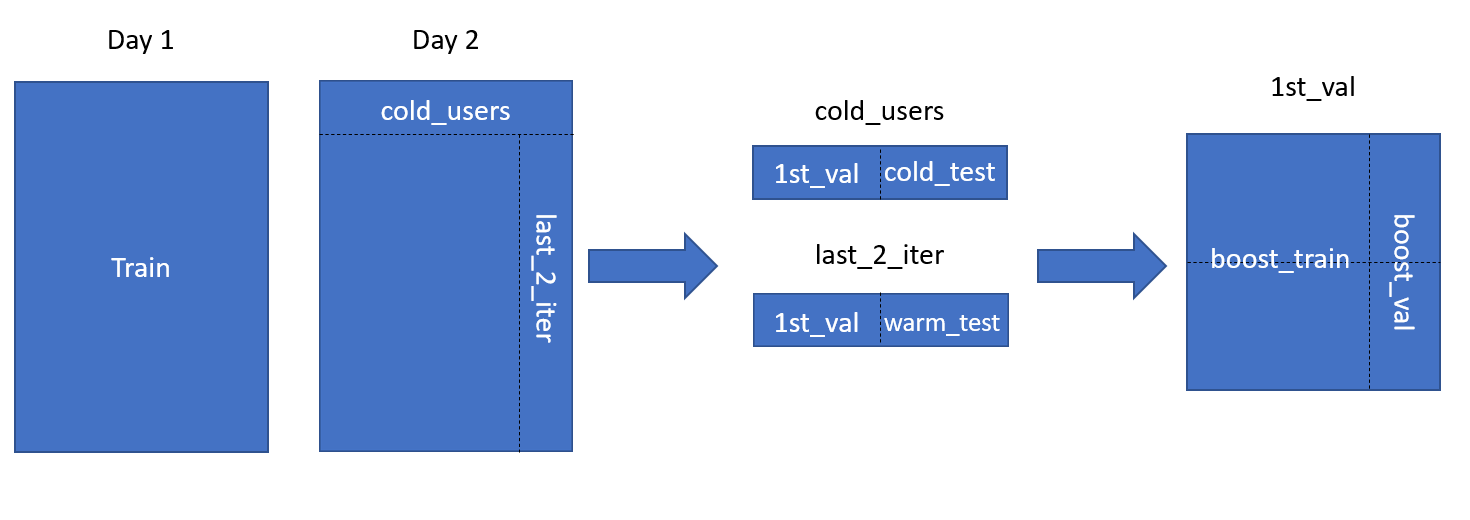

#### Создание выборок по шагам:

1. Так как нет признаков для пользователей, а так же в целях повышения производительности моделей, отфильтруем пользователей и товары (>=5 взаимодействий для пользователей и >=2 взаимодействий для товаров)
2. 10 день оставляем полностью под трейн
3. Из 11 дня выбираем рандомно 10% пользователей, которые взаимодействовали только в 11 день. Они будут холодными пользователями (cold_users)
4. У оставшихся пользователей выбираем 4 последних взаимодействия. Это будут теплые пользователи (last_4_iter)
5. Делим cold_users. Одна половина станет общим тестом итоговой модели для проверки работоспособности на холодных пользователях (cold_test). Вторая пойдет в валидационный датасет моделей первого этапа (first_val_cold)
6. Аналогично поступаем для last_4_iter. Одна половина станет тестом итоговом модели для проверки на теплых пользователях (warm_test). Вторая пойдет в валидационный датасет (first_val_warm)
7. first_val так же надо разбить на boost_train и boost_val. Деление будет происходить так: отдельно из 1st_val_cold и 1st_val_warm берем рандомных пользователей так, чтобы конечное разделение получилось примерно 80%/20%. (first_val_warm_train/first_val_warm_val и first_val_cold_train/first_val_cold_val)
8. Объединяем first_val_warm_train и first_val_cold_train в boost_train, а first_val_warm_val и first_val_cold_val в boost_val

Преимущества используемого подхода:
* Оставляем достаточно данных на обучение модели
* Полученные выборки получаются достаточно сбалансированными
* Полученные выборки достаточно интерпретируемы, так же учитываем взаимодействия в течение всего дня, а не нескольких последних часов
* Сохраняется хронологический порядок действий пользователей
* Модель обучается и на теплых и на холодных пользователях
* Мы можем отдельно проверить работоспособность модели на холодных и на теплых пользователях

#### Теперь создадим эти выборки

In [21]:
user_counts = df['wbuser_id'].value_counts()

In [22]:
print(len(user_counts[user_counts >= 5]))
print(len(user_counts[user_counts >= 6]))
print(len(user_counts[user_counts >= 10]))
print(len(user_counts[user_counts >= 11]))
print(len(user_counts[user_counts >= 12]))
print(len(user_counts[user_counts >= 14]))

1939078
1762740
1291300
1208994
1136059
1012484


In [26]:
users_to_keep = user_counts[user_counts >= 5].index

filtered_df = df[df['nm_id'].isin(users_to_keep)]

In [27]:
item_counts = filtered_df['nm_id'].value_counts()

In [28]:
print(len(item_counts[item_counts <= 2]))

0


In [30]:
# Пользователи, взаимодействия которых только в 11-й день
only_day_11_users = filtered_df.groupby('wbuser_id')['day'].unique()
only_day_11_users = [user for user, days in only_day_11_users.items() if set(days) == {11}]

# Количество таких пользователей
count_only_day_11_users = len(only_day_11_users)

# Пользователи, которые взаимодействовали и в 10-й, и в 11-й день
both_days_users = filtered_df.groupby('wbuser_id')['day'].unique()
both_days_users = [user for user, days in both_days_users.items() if set(days) == {10, 11}]

# Количество таких пользователей
count_both_days_users = len(both_days_users)

In [31]:
count_only_day_11_users, count_both_days_users

(1148549, 544503)

In [32]:
# Установка фиксированного состояния для воспроизводимости
random_seed = 42

# Преобразуем список в Series для использования метода sample
only_day_11_series = pd.Series(only_day_11_users)

# Вычисляем 10% от общего количества пользователей
fraction = 0.1

# Выбираем случайные 15% пользователей
cold_users_selected = only_day_11_series.sample(frac=fraction, random_state=random_seed).tolist()

print(f"Выбрано {len(cold_users_selected)} пользователей для cold_users.")

Выбрано 114855 пользователей для cold_users.


In [33]:
# Создание DataFrame для cold_users
cold_users = filtered_df[filtered_df['wbuser_id'].isin(cold_users_selected)].copy()

print(f"cold_users содержит {len(cold_users)} взаимодействий.")

# Удаление взаимодействий cold_users из исходного DataFrame
filtered_df = filtered_df[~filtered_df['wbuser_id'].isin(cold_users_selected)].copy()

print(f"Оставшиеся взаимодействия после удаления cold_users: {len(filtered_df)}")

cold_users содержит 666226 взаимодействий.
Оставшиеся взаимодействия после удаления cold_users: 22688467


In [34]:
# Получение списка оставшихся only_day_11_users после удаления cold_users
remaining_only_day_11_users = list(set(only_day_11_users) - set(cold_users_selected))

print(f"Оставшихся пользователей только в день 11: {len(remaining_only_day_11_users)}")

# Фильтрация взаимодействий для оставшихся пользователей only_day_11_users
only_day_11_remaining_df = filtered_df[filtered_df['wbuser_id'].isin(remaining_only_day_11_users)].copy()

# Фильтрация по времени
only_day_11_remaining_df = only_day_11_remaining_df.sort_values(['wbuser_id', 'dt'])

# Выбор последних 4 взаимодействий для каждого пользователя
warm_users = only_day_11_remaining_df.groupby('wbuser_id').tail(4).copy()

print(f"warm_users содержит {len(warm_users)} взаимодействий.")

# Удаление взаимодействий warm_users из исходного DataFrame
warm_user_indexes = warm_users.index
filtered_df = filtered_df.drop(warm_user_indexes).copy()

print(f"Оставшиеся взаимодействия после удаления warm_users: {len(filtered_df)}")

Оставшихся пользователей только в день 11: 1033694
warm_users содержит 2588604 взаимодействий.
Оставшиеся взаимодействия после удаления warm_users: 20099863


In [35]:
# Установка фиксированного состояния для воспроизводимости
random_seed = 42

# Функция для случайного разбиения пользователей на две части (50% на 50%)
def split_users(df, user_column='wbuser_id', frac=0.5, random_state=None):
    unique_users = df[user_column].unique()
    unique_users_df = pd.DataFrame(unique_users, columns=[user_column])

    # Перемешиваем пользователей
    shuffled_users = unique_users_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Определяем размер первой части
    split_index = int(len(shuffled_users) * frac)

    # Разделяем пользователей
    first_part_users = shuffled_users.iloc[:split_index][user_column].tolist()
    second_part_users = shuffled_users.iloc[split_index:][user_column].tolist()

    return first_part_users, second_part_users

# Разбиение cold_users на first_val_cold и cold_test
first_val_cold_users, cold_test_users = split_users(cold_users, user_column='wbuser_id',
                                                   frac=0.5, random_state=random_seed)

print(f"Количество пользователей в first_val_cold: {len(first_val_cold_users)}")
print(f"Количество пользователей в cold_test: {len(cold_test_users)}")

# Создание DataFrame для first_val_cold и cold_test
first_val_cold = cold_users[cold_users['wbuser_id'].isin(first_val_cold_users)].copy()
cold_test = cold_users[cold_users['wbuser_id'].isin(cold_test_users)].copy()

# Разбиение warm_users на first_val_warm и warm_test
first_val_warm_users, warm_test_users = split_users(warm_users, user_column='wbuser_id',
                                                   frac=0.5, random_state=random_seed)

print(f"Количество пользователей в first_val_warm: {len(first_val_warm_users)}")
print(f"Количество пользователей в warm_test: {len(warm_test_users)}")

# Создание DataFrame для first_val_warm и warm_test
first_val_warm = warm_users[warm_users['wbuser_id'].isin(first_val_warm_users)].copy()
warm_test = warm_users[warm_users['wbuser_id'].isin(warm_test_users)].copy()

# Объединение first_val_cold и first_val_warm в first_val
first_val = pd.concat([first_val_cold, first_val_warm], ignore_index=True)

print(f"Итоговый набор first_val содержит {first_val.shape} взаимодействий.")
print(f"first_val_cold: {first_val_cold.shape}")
print(f"cold_test: {cold_test.shape}")
print(f"first_val_warm: {first_val_warm.shape}")
print(f"warm_test: {warm_test.shape}")
print(f"first_val: {first_val.shape}")

Количество пользователей в first_val_cold: 57427
Количество пользователей в cold_test: 57428
Количество пользователей в first_val_warm: 516847
Количество пользователей в warm_test: 516847
Итоговый набор first_val содержит (1627461, 5) взаимодействий.
first_val_cold: (333373, 5)
cold_test: (332853, 5)
first_val_warm: (1294088, 5)
warm_test: (1294516, 5)
first_val: (1627461, 5)


In [ ]:
# Функция для выборки случайных пользователей
def sample_users(df, fraction=0.2, random_state=42):
    unique_users = df['wbuser_id'].unique()
    sampled_users = pd.Series(unique_users).sample(frac=fraction, random_state=random_state).tolist()
    return sampled_users

# Выбор 20% пользователей из каждого датафрейма
sampled_cold_users = sample_users(first_val_cold, fraction=0.2, random_state=42)
sampled_warm_users = sample_users(first_val_warm, fraction=0.2, random_state=42)

# Создание boost_val из выбранных пользователей
boost_val_cold = first_val_cold[first_val_cold['wbuser_id'].isin(sampled_cold_users)]
boost_val_warm = first_val_warm[first_val_warm['wbuser_id'].isin(sampled_warm_users)]
boost_val = pd.concat([boost_val_cold, boost_val_warm]).reset_index(drop=True)

# Удаление выбранных взаимодействий из исходных датафреймов
first_val_cold_remaining = first_val_cold[~first_val_cold['wbuser_id'].isin(sampled_cold_users)]
first_val_warm_remaining = first_val_warm[~first_val_warm['wbuser_id'].isin(sampled_warm_users)]

# Создание boost_train из оставшихся взаимодействий
boost_train = pd.concat([first_val_cold_remaining, first_val_warm_remaining]).reset_index(drop=True)

In [ ]:
boost_train.to_parquet('boost_train.parquet')
boost_val.to_parquet('boost_val.parquet')
first_val.to_parquet('first_val.parquet')
cold_test.to_parquet('cold_test.parquet')
warm_test.to_parquet('warm_test.parquet')
df.to_parquet('first_train.parquet')

# 2. Новый способ получения эмбеддингов для изображений

#### Сначала создадим признак, который будет содержать нормированную популярность товара в обучающей выборке

In [ ]:
interactions_df = pd.read_parquet('first_train.parquet')

In [ ]:
interactions_df = interactions_df.drop(['dt', 'day', 'hour'], axis=1)

In [ ]:
total_users_interactions_count = interactions_df[["wbuser_id", "user_item_count"]].groupby("wbuser_id").sum().rename(columns={"user_item_count": "user_inter_count",})

In [ ]:
interactions_df = interactions_df.join(total_users_interactions_count,on="wbuser_id",how="left")

interactions_df["user_item_rating"] = interactions_df["user_item_count"] / interactions_df["user_inter_count"]

In [ ]:
item_popul_df = interactions_df[["nm_id", "user_item_count"]].groupby("nm_id").sum().rename(columns={"user_item_count": "item_count",})

item_popul_df["item_popul"] = item_popul_df["item_count"] / item_popul_df.shape[0]

item_popul_df = item_popul_df.reset_index()

In [ ]:
item_popul_df = item_popul_df.sort_values("item_popul", ascending=False)

In [ ]:
items = pd.read_parquet('image_exists.parquet')

In [ ]:
embeddings = pd.read_parquet('emb_final.parquet')

In [ ]:
result = items.merge(item_popul_df, on='nm_id', how='left')

In [ ]:
result.index = items.index

In [ ]:
items = result

In [ ]:
items = items.drop(['item_count'], axis=1)

In [ ]:
items *= 1
items = items.fillna(0)

In [ ]:
items.index = items.index.astype(int)
embeddings.index = embeddings.index.astype(int)

In [ ]:
items.index.name = None
embeddings.index.name = None

In [ ]:
items = pd.merge(
    items,
    embeddings['emb_256'],
    left_index=True,
    right_index=True,
    how='left'
)

In [ ]:
items.to_parquet('items_min.parquet')

### Теперь создание эмбеддингов

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

In [ ]:
import zipfile
# Пути к файлам
zip_path = 'images.zip'
extract_path = '/content/images'

# Распаковываем архив
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Проверяем содержимое папки
print("Содержимое папки images:", os.listdir('/content/images/images')[:5])

In [ ]:
IMAGE_DIR = '/content/images/images'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
DEFAULT_EMBEDDING = np.zeros(4096)  # Размер эмбеддинга для VGG16 слоя 'fc2'

In [ ]:
# Инициализация TPU
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Обнаружение TPU
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Используется TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Использование CPU/GPU
    print("TPU не обнаружен. Используется CPU/GPU")

In [ ]:
# Настройка модели внутри стратегии распределения
with strategy.scope():
    base_model = VGG16(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [ ]:
result_df = pd.read_parquet('mini_without_images.parquet')

In [ ]:
image_indices = result_df.index.astype(str).tolist()
image_filenames = [f"{idx}.jpg" for idx in image_indices]
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]

In [ ]:
existing_mask = [os.path.exists(path) for path in image_paths]
result_df['image_exists'] = existing_mask

In [ ]:
result_df.to_parquet('image_exists.parquet')

In [ ]:
existing_paths = [path for path, exists in zip(image_paths, existing_mask) if exists]
existing_ids = [os.path.splitext(os.path.basename(path))[0] for path in existing_paths]

print(f"Найдено {len(existing_paths)} существующих изображений из {len(image_paths)}")

In [ ]:
embeddings_data = {
    'image_id': image_indices,
    'embedding': [DEFAULT_EMBEDDING.tolist()] * len(image_indices),  # Инициализация значениями по умолчанию
    'image_exists': existing_mask
}

embeddings_df = pd.DataFrame(embeddings_data)

In [ ]:
embeddings_df = pd.read_parquet('emb_256.parquet')

In [ ]:
num_images = len(existing_paths)
num_batches = (num_images + BATCH_SIZE - 1) // BATCH_SIZE

In [ ]:
def load_and_preprocess_images(batch_paths):
    batch_images = []
    batch_ids = []
    for path in batch_paths:
        try:
            img = image.load_img(path, target_size=IMAGE_SIZE)
            x = image.img_to_array(img)
            batch_images.append(x)
            current_id = os.path.splitext(os.path.basename(path))[0]
            batch_ids.append(current_id)
        except Exception as e:
            print(f"Ошибка при загрузке {path}: {e}")
            continue
    if not batch_images:
        return None, None
    x = np.array(batch_images)
    x = preprocess_input(x)
    return x, batch_ids

In [ ]:
from tqdm import tqdm

In [ ]:
embeddings_df.set_index('image_id', inplace=True)

In [ ]:
for batch_num in tqdm(range(num_batches), desc="Обработка изображений на батчах"):
    batch_paths = existing_paths[batch_num * BATCH_SIZE : (batch_num + 1) * BATCH_SIZE]
    batch_ids = []
    batch_images = []

    for path in batch_paths:
        try:
            img = image.load_img(path, target_size=IMAGE_SIZE)
            x = image.img_to_array(img)
            batch_images.append(x)
            current_id = os.path.splitext(os.path.basename(path))[0]
            batch_ids.append(current_id)
        except Exception as e:
            print(f"Ошибка при загрузке {path}: {e}")
            continue

    if not batch_images:
        continue

    x = np.array(batch_images)
    x = preprocess_input(x)

    # Извлечение эмбеддингов
    features_batch = model.predict(x, batch_size=BATCH_SIZE)

    # Обновление DataFrame с эмбеддингами
    for i, item_id in enumerate(batch_ids):
        if item_id in embeddings_df.index:
            embeddings_df.at[item_id, 'embedding'] = features_batch[i].tolist()
        else:
            print(f"Предупреждение: image_id {item_id} не найден в embeddings_df")

print("Эмбеддинги успешно извлечены.")

# Сохранение результата
embeddings_df.to_parquet('embeddings_only.parquet', index=False)

print("Эмбеддинги успешно сохранены в 'embeddings_only.parquet'")

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Проверка на наличие пропусков
if embeddings_df['embedding'].isnull().any():
    raise ValueError("Есть пропущенные значения в колонке 'embedding'.")

# Преобразование эмбеддингов в numpy массив
X = np.vstack(embeddings_df['embedding'].values)

print(f"Форма входных данных: {X.shape}")

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, GaussianNoise, BatchNormalization, LeakyReLU, Dropout

# Параметры модели
input_dim = 4096
encoding_dim = 256      # Размерность закодированного представления

with strategy.scope():
    def create_autoencoder(input_dim, encoding_dim):
        # Входной слой
        input_layer = Input(shape=(input_dim,), name="Input")

        # Добавление Gaussian шума для регуляризации
        x = GaussianNoise(stddev=0.1)(input_layer)

        # Энкодер
        x = Dense(2048, kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)

        x = Dense(1024, kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)

        x = Dense(512, kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)

        encoded = Dense(encoding_dim, activation='relu', name='encoded_layer')(x)

        # Декодер
        y = Dense(512, kernel_regularizer=l2(1e-4))(encoded)
        y = BatchNormalization()(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)

        y = Dense(1024, kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)

        y = Dense(2048, kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)

        decoded = Dense(input_dim, activation='linear', name='decoded_layer')(y)

        # Создание модели
        autoencoder = models.Model(inputs=input_layer, outputs=decoded)

        return autoencoder

    # Создание модели
    autoencoder = create_autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)

    # Компиляция модели
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Вывод сводки модели
    autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 4096)]            0         
                                                                 
 gaussian_noise (GaussianNo  (None, 4096)              0         
 ise)                                                            
                                                                 
 dense (Dense)               (None, 2048)              8390656   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
num_samples = len(X)      # Общее количество образцов
input_dim = 4096

# Разделение на обучающую и валидационную выборки
split = int(num_samples * 0.8)
X_train, X_val = X[:split], X[split:]

# Параметры для Dataset
batch_size = 128 * strategy.num_replicas_in_sync
buffer_size = 10000

# Создание tf.data.Dataset для обучения
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Создание tf.data.Dataset для валидации
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, X_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Путь для сохранения лучшей модели
checkpoint_filepath = 'best_autoencoder_tpu.h5'

# Ранняя остановка: останавливаем обучение, если не улучшается метрика в течение 10 эпох
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Понижение скорости обучения: уменьшаем lr, если не улучшается метрика в течение 5 эпох
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6, verbose=1)

# Сохранение лучшей модели
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
# Обучение модели
history = autoencoder.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

In [ ]:
# Определение модели энкодера
encoder = models.Model(inputs=autoencoder.input,
                       outputs=autoencoder.get_layer('encoded_layer').output,
                       name='Encoder')

# Вывод сводки модели энкодера
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 4096)]            0         
                                                                 
 gaussian_noise (GaussianNo  (None, 4096)              0         
 ise)                                                            
                                                                 
 dense (Dense)               (None, 2048)              8390656   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0   

In [ ]:
emb_256 = encoder.predict(X, batch_size=1024)

print(f"Форма полученных эмбеддингов: {emb_256.shape}")

In [ ]:
embeddings_df['emb_256'] = emb_256.tolist()

In [ ]:
embeddings_df.to_parquet('emb_256_final.parquet')

##### Аналогично я сделал для размерности 512. Получилось значительно ускорить процесс создания эмбеддингов, а так же увеличить точность: для 256 val_mse: 0.2697, val_mae: 0.2871; для 512 val_mse: 0.1385, val_mae: 0.2494

# 3. Метрики

1. MAP

2. Recall

3. MRR

4. Serendipity

5. HR

6. pop_bias

# 4. Обнаруженные проблемы:
##### При работе в гугл колабе в среде с TPU (так как в других средах не хватает памяти), было обнаружено, что RecTools LightFM и стандартный LightFM конфликтуют с tensorflow, но даже после удаления tensorflow и установки tensorflow-cpu (и без установки этой библиотеки) алгоритм в этой среде работает медленнее, чем в обычной среде выполнения, даже не смотря на то, что в этой среде 96 ядер вместо двух. Рекомендации в обычной среде выполнения даже после некоторого уменьшения датасета считались очень долго. Поэтому было принято решение до защиты данного этапа уменьшить датасет, чтобы провести некоторые эксперименты с моделями. Так же можно отметить, что RecTools EASE потребляет очень много оперативной памяти и я смог его применить только после финального варианта уменьшения датасета

# Уменьшение датасета

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_parquet('clickstream.parquet')

In [ ]:
user_counts = df['wbuser_id'].value_counts()

In [ ]:
print(len(user_counts[user_counts >= 10]))
print(len(user_counts[user_counts >= 11]))
print(len(user_counts[user_counts >= 12]))
print(len(user_counts[user_counts >= 14]))

1291300
1208994
1136059
1012484


In [ ]:
item_counts = df['nm_id'].value_counts()

In [ ]:
print(len(item_counts[item_counts >= 10]))

211680


In [ ]:
items_to_keep = item_counts[item_counts >= 10].index

filtered_df = df[df['nm_id'].isin(items_to_keep)]

In [ ]:
for i in range(4):
  # Установка фиксированного состояния для воспроизводимости
  random_seed = 42

  # Получение уникальных значений nm_id
  unique_nm_ids = filtered_df['nm_id'].unique()
  total_unique = len(unique_nm_ids)
  print(f"Всего уникальных nm_id: {total_unique}")

  # Расчёт количества nm_id для удаления (50%)
  num_to_remove = total_unique // 2  # Используем целочисленное деление

  # Случайный выбор 50% nm_id
  # Используем функцию np.random.choice для случайного выбора без замены
  np.random.seed(random_seed)
  nm_ids_to_remove = np.random.choice(unique_nm_ids, size=num_to_remove, replace=False)

  print(f"Количество nm_id, которые будут удалены: {len(nm_ids_to_remove)}")

  # Фильтрация датафрейма для удаления строк с выбранными nm_id
  filtered_df_remaining = filtered_df[~filtered_df['nm_id'].isin(nm_ids_to_remove)].copy()

  print(f"Количество строк до удаления: {filtered_df.shape[0]}")
  print(f"Количество строк после удаления: {filtered_df_remaining.shape[0]}")
  filtered_df = filtered_df_remaining

Всего уникальных nm_id: 211680
Количество nm_id, которые будут удалены: 105840
Количество строк до удаления: 58290492
Количество строк после удаления: 28932345
Всего уникальных nm_id: 105840
Количество nm_id, которые будут удалены: 52920
Количество строк до удаления: 28932345
Количество строк после удаления: 14316641
Всего уникальных nm_id: 52920
Количество nm_id, которые будут удалены: 26460
Количество строк до удаления: 14316641
Количество строк после удаления: 7050930
Всего уникальных nm_id: 26460
Количество nm_id, которые будут удалены: 13230
Количество строк до удаления: 7050930
Количество строк после удаления: 3531679


In [ ]:
user_counts = filtered_df['wbuser_id'].value_counts()

In [ ]:
print(len(user_counts[user_counts >= 5]))
print(len(user_counts[user_counts >= 6]))
print(len(user_counts[user_counts >= 10]))
print(len(user_counts[user_counts >= 11]))
print(len(user_counts[user_counts >= 12]))
print(len(user_counts[user_counts >= 14]))

193736
141790
50870
40930
33298
22617


In [ ]:
users_to_keep = user_counts[user_counts >= 5].index

filtered_df = filtered_df[filtered_df['wbuser_id'].isin(users_to_keep)]

In [ ]:
item_counts = filtered_df['nm_id'].value_counts()
print(len(item_counts[item_counts <= 2]))

230


In [ ]:
items_to_keep = item_counts[item_counts >= 3].index

filtered_df = filtered_df[filtered_df['nm_id'].isin(items_to_keep)]

In [ ]:
user_counts = filtered_df['wbuser_id'].value_counts()
print(len(user_counts[user_counts <= 5]))

51999


In [ ]:
users_to_keep = user_counts[user_counts >= 5].index

filtered_df = filtered_df[filtered_df['wbuser_id'].isin(users_to_keep)]

In [ ]:
item_counts = filtered_df['nm_id'].value_counts()
print(len(item_counts[item_counts <= 2]))

0


In [ ]:
items_to_keep = item_counts[item_counts >= 3].index

filtered_df = filtered_df[filtered_df['nm_id'].isin(items_to_keep)]

In [ ]:
user_counts = filtered_df['wbuser_id'].value_counts()
print(len(user_counts[user_counts <= 5]))

51939


In [ ]:
item_counts = filtered_df['nm_id'].value_counts()
print(len(item_counts[item_counts <= 2]))

0


In [ ]:
filtered_df.to_parquet('cut_clickstream_2.paqruet')

In [ ]:
filtered_df = pd.read_parquet('cut_clickstream_2.paqruet')

In [ ]:
# Пользователи, взаимодействия которых только в 11-й день
only_day_11_users = filtered_df.groupby('wbuser_id')['day'].unique()
only_day_11_users = [user for user, days in only_day_11_users.items() if set(days) == {11}]

# Количество таких пользователей
count_only_day_11_users = len(only_day_11_users)

# Пользователи, которые взаимодействовали и в 10-й, и в 11-й день
both_days_users = filtered_df.groupby('wbuser_id')['day'].unique()
both_days_users = [user for user, days in both_days_users.items() if set(days) == {10, 11}]

# Количество таких пользователей
count_both_days_users = len(both_days_users)

In [ ]:
count_only_day_11_users, count_both_days_users

(57634, 76960)

In [ ]:
# Установка фиксированного состояния для воспроизводимости
random_seed = 42

# Преобразуем список в Series для использования метода sample
only_day_11_series = pd.Series(only_day_11_users)

# Вычисляем 10% от общего количества пользователей
fraction = 0.1

# Выбираем случайные 15% пользователей
cold_users_selected = only_day_11_series.sample(frac=fraction, random_state=random_seed).tolist()

print(f"Выбрано {len(cold_users_selected)} пользователей для cold_users.")

Выбрано 5763 пользователей для cold_users.


In [ ]:
# Создание DataFrame для cold_users
cold_users = filtered_df[filtered_df['wbuser_id'].isin(cold_users_selected)].copy()

print(f"cold_users содержит {len(cold_users)} взаимодействий.")

# Удаление взаимодействий cold_users из исходного DataFrame
filtered_df = filtered_df[~filtered_df['wbuser_id'].isin(cold_users_selected)].copy()

print(f"Оставшиеся взаимодействия после удаления cold_users: {len(filtered_df)}")

cold_users содержит 45376 взаимодействий.
Оставшиеся взаимодействия после удаления cold_users: 1637902


In [ ]:
# Получение списка оставшихся only_day_11_users после удаления cold_users
remaining_only_day_11_users = list(set(only_day_11_users) - set(cold_users_selected))

print(f"Оставшихся пользователей только в день 11: {len(remaining_only_day_11_users)}")

# Фильтрация взаимодействий для оставшихся пользователей only_day_11_users
only_day_11_remaining_df = filtered_df[filtered_df['wbuser_id'].isin(remaining_only_day_11_users)].copy()

# Фильтрация по времени
 only_day_11_remaining_df = only_day_11_remaining_df.sort_values(['wbuser_id', 'dt'])

# Выбор последних 4 взаимодействий для каждого пользователя
warm_users = only_day_11_remaining_df.groupby('wbuser_id').tail(4).copy()

print(f"warm_users содержит {len(warm_users)} взаимодействий.")

# Удаление взаимодействий warm_users из исходного DataFrame
warm_user_indexes = warm_users.index
filtered_df = filtered_df.drop(warm_user_indexes).copy()

print(f"Оставшиеся взаимодействия после удаления warm_users: {len(filtered_df)}")


Оставшихся пользователей только в день 11: 51871
warm_users содержит 207484 взаимодействий.
Оставшиеся взаимодействия после удаления warm_users: 1430418


In [ ]:
# Установка фиксированного состояния для воспроизводимости
random_seed = 42

# Функция для случайного разбиения пользователей на две части (50% на 50%)
def split_users(df, user_column='wbuser_id', frac=0.5, random_state=None):
    unique_users = df[user_column].unique()
    unique_users_df = pd.DataFrame(unique_users, columns=[user_column])

    # Перемешиваем пользователей
    shuffled_users = unique_users_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Определяем размер первой части
    split_index = int(len(shuffled_users) * frac)

    # Разделяем пользователей
    first_part_users = shuffled_users.iloc[:split_index][user_column].tolist()
    second_part_users = shuffled_users.iloc[split_index:][user_column].tolist()

    return first_part_users, second_part_users

# Разбиение cold_users на first_val_cold и cold_test
first_val_cold_users, cold_test_users = split_users(cold_users, user_column='wbuser_id',
                                                   frac=0.5, random_state=random_seed)

print(f"Количество пользователей в first_val_cold: {len(first_val_cold_users)}")
print(f"Количество пользователей в cold_test: {len(cold_test_users)}")

# Создание DataFrame для first_val_cold и cold_test
first_val_cold = cold_users[cold_users['wbuser_id'].isin(first_val_cold_users)].copy()
cold_test = cold_users[cold_users['wbuser_id'].isin(cold_test_users)].copy()

# Разбиение warm_users на first_val_warm и warm_test
first_val_warm_users, warm_test_users = split_users(warm_users, user_column='wbuser_id',
                                                   frac=0.5, random_state=random_seed)

print(f"Количество пользователей в first_val_warm: {len(first_val_warm_users)}")
print(f"Количество пользователей в warm_test: {len(warm_test_users)}")

# Создание DataFrame для first_val_warm и warm_test
first_val_warm = warm_users[warm_users['wbuser_id'].isin(first_val_warm_users)].copy()
warm_test = warm_users[warm_users['wbuser_id'].isin(warm_test_users)].copy()

# Объединение first_val_cold и first_val_warm в first_val
first_val = pd.concat([first_val_cold, first_val_warm], ignore_index=True)

print(f"Итоговый набор first_val содержит {first_val.shape} взаимодействий.")
print(f"first_val_cold: {first_val_cold.shape}")
print(f"cold_test: {cold_test.shape}")
print(f"first_val_warm: {first_val_warm.shape}")
print(f"warm_test: {warm_test.shape}")
print(f"first_val: {first_val.shape}")

Количество пользователей в first_val_cold: 2881
Количество пользователей в cold_test: 2882
Количество пользователей в first_val_warm: 25935
Количество пользователей в warm_test: 25936
Итоговый набор first_val содержит (126525, 5) взаимодействий.
first_val_cold: (22785, 5)
cold_test: (22591, 5)
first_val_warm: (103740, 5)
warm_test: (103744, 5)
first_val: (126525, 5)


In [ ]:
filtered_df = filtered_df.drop(['day', 'hour'], axis=1)

In [ ]:
warm_test = warm_test.drop(['day', 'hour'], axis=1)
cold_test = cold_test.drop(['day', 'hour'], axis=1)
first_val = first_val.drop(['day', 'hour'], axis=1)

In [ ]:
filtered_df.to_parquet('first_train_2.parquet', index=False)
cold_test.to_parquet('cold_test_2.parquet', index=False)
warm_test.to_parquet('warm_test_2.parquet', index=False)
first_val.to_parquet('first_val_2.parquet', index=False)

# 5. Проведение некоторых экспериментов с моделями

In [ ]:
!pip install rectools[all]

In [ ]:
!pip install lightfm

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

Mounted at /content/drive


In [ ]:
from rectools.metrics import (
    HitRate,
    Serendipity,
    calc_metrics,
    Recall,
    MAP,
    MRR,
    AvgRecPopularity
)
from rectools import Columns
from rectools.dataset import Dataset

In [ ]:
first_train = pd.read_parquet('first_train_2.parquet')
first_val = pd.read_parquet('first_val_2.parquet')

In [ ]:
first_train['watched'] = 1
first_val['watched'] = 1

In [ ]:
first_train = first_train.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [ ]:
first_val = first_val.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [ ]:
first_train_df = Dataset.construct(first_train)
first_val_df = Dataset.construct(first_val)

In [ ]:
from rectools.models import PopularModel

model = PopularModel()
model.fit(first_train_df)
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

In [ ]:
recos

,user_id,item_id,score,rank
0,2104069,73874,7132.0,1
1,2104069,82949,3512.0,2
2,2104069,197567,3381.0,3
3,2104069,25132,3171.0,4
4,2104069,312716,2915.0,5
...,...,...,...,...
576315,1054256,208215,2101.0,16
576316,1054256,24960,1935.0,17
576317,1054256,276234,1901.0,18
576318,1054256,22240,1857.0,19


In [ ]:
catalog = first_train[Columns.Item].unique()

In [ ]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}

calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog,
)

{'hit_rate@20': 0.15133953359244864,
 'Recall@20': 0.055042811047654294,
 'MRR@20': 0.04505636044032271,
 'MAP@20': 0.014900224394509408,
 'pop_bias@20': 4121.849999999999,
 'serendipity@20': 5.346929180098021e-07}

In [ ]:
from lightfm import LightFM
from rectools.models import LightFMWrapperModel

In [ ]:
num_threads = os.cpu_count()
num_threads

2

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=15, verbose=1)
model.fit(first_train_df);

Epoch: 100%|██████████| 15/15 [00:49<00:00,  3.27s/it]


In [ ]:
%time
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 18.6 µs


In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.5330372015546918,
 'Recall@20': 0.28295505849304725,
 'MRR@20': 0.27549407677123233,
 'MAP@20': 0.15217030760121422,
 'pop_bias@20': 1867.573445308162,
 'serendipity@20': 0.0014486074033263259}

In [ ]:
from rectools.models import EASEModel

In [ ]:
model = EASEModel(verbose=1, num_threads=num_threads)
model.fit(first_train_df)

In [ ]:
%time
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
    on_unsupported_targets = 'ignore',
)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.49899361465852304,
 'Recall@20': 0.2585629511382565,
 'MRR@20': 0.2934001541945354,
 'MAP@20': 0.14644650258241665,
 'pop_bias@20': 346.0136495083863,
 'serendipity@20': 0.001990639920527485}

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=2, verbose=1)
model.fit(first_train_df);

Epoch: 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]


In [ ]:
%time
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.06 µs


In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.3982856746252082,
 'Recall@20': 0.1965411782760866,
 'MRR@20': 0.1961844189297228,
 'MAP@20': 0.10152629438795059,
 'pop_bias@20': 2388.9143097584674,
 'serendipity@20': 0.0009918298384921059}

In [ ]:
items = pd.read_parquet('items_min.parquet')

In [ ]:
items = items.rename(
    columns={
        'nm_id': Columns.Item,
    }
)

In [ ]:
items = items.loc[items[Columns.Item].isin(first_train[Columns.Item])].copy()

In [ ]:
# Определяем колонки, которые нужно оставить
columns_to_keep_numeric = [str(i) for i in range(100)]
columns_to_keep_emb = [f'emb_{i}' for i in range(256)]
columns_to_keep = columns_to_keep_numeric # + columns_to_keep_emb

# Оставляем только выбранные колонки
items = items[columns_to_keep + ['item_id']]


In [ ]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [ ]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    make_dense_item_features=False  # for `sparse` format
)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=2, verbose=1)
model.fit(sparse_features_dataset);

Epoch: 100%|██████████| 2/2 [03:19<00:00, 99.78s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.35900194336479735,
 'Recall@20': 0.17254795922631042,
 'MRR@20': 0.14870468661847625,
 'MAP@20': 0.07453546715013187,
 'pop_bias@20': 2100.9358863131592,
 'serendipity@20': 0.0008132559795057523}

In [ ]:
# Определяем бинарные колонки (колонки с двумя уникальными значениями)
binary_cols = [col for col in items.columns if items[col].nunique() == 2 and col != 'item_id']

# Определяем числовые колонки, исключая бинарные
numeric_cols = [col for col in items.select_dtypes(include=[np.number]).columns if col not in binary_cols + ['item_id']]

In [ ]:
NUM_QUANTILES = 5

# Функция для преобразования значений в метки квантилей вида 'колонка_квантиль'
def assign_quantile_labels(df, columns, num_quantiles=10):
    for col in columns:
        try:
            # Создаём метки для квантилей, например, '0_1', '0_2', ..., '0_5'
            quantile_labels = [f"{col}_{i}" for i in range(1, num_quantiles + 1)]

            # Используем pd.qcut для разбиения на квантильные интервалы с заданными метками
            df[col + '_quantile'] = pd.qcut(df[col], q=num_quantiles, labels=quantile_labels)
        except ValueError as e:
            print(f"Ошибка при обработке столбца {col}: {e}")
            unique_values = df[col].nunique()
            if unique_values < num_quantiles:
                # Создаём метки для существующего количества квантилей
                adjusted_labels = [f"{col}_{i}" for i in range(1, unique_values + 1)]
                df[col + '_quantile'] = pd.qcut(df[col], q=unique_values, labels=adjusted_labels)
            else:
                raise e
    return df

# Список колонок с названиями от '0' до '99'
columns_to_transform = numeric_cols

# Применяем функцию к копии DataFrame
items_transformed = assign_quantile_labels(items.copy(), columns_to_transform, NUM_QUANTILES)

# Заменяем исходные колонки на квантильные метки
for col in columns_to_transform:
    quantile_col = col + '_quantile'
    if quantile_col in items_transformed.columns:
        items_transformed.drop(columns=[col], inplace=True)
        items_transformed.rename(columns={quantile_col: col}, inplace=True)

In [ ]:
items = items_transformed

NameError: name 'items_transformed' is not defined

In [ ]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [ ]:
item_features = item_features.sort_values('id')

In [ ]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    cat_item_features = columns_to_transform,
    make_dense_item_features=False  # for `sparse` format
)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=2, verbose=1)
model.fit(sparse_features_dataset);

Epoch: 100%|██████████| 2/2 [05:02<00:00, 151.47s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.01679622431982232,
 'Recall@20': 0.004807533305449325,
 'MRR@20': 0.007497096191645617,
 'MAP@20': 0.0017959293871372135,
 'pop_bias@20': 251.39020509439203,
 'serendipity@20': 2.041517148062449e-05}

In [ ]:
# Импортируем необходимый класс
from sklearn.preprocessing import MinMaxScaler

# Определяем бинарные колонки (колонки с двумя уникальными значениями)
binary_cols = [col for col in items.columns if items[col].nunique() == 2 and col != 'item_id']

# Определяем числовые колонки, исключая бинарные
numeric_cols = [col for col in items.select_dtypes(include=[np.number]).columns if col not in binary_cols + ['item_id']]

# Инициализируем скейлер
scaler = MinMaxScaler()

# Создаем DataFrame для масштабированных данных
items_scaled = items.copy()

# Применяем масштабирование только к числовым колонкам
items_scaled[numeric_cols] = scaler.fit_transform(items_scaled[numeric_cols])

items[numeric_cols] = items_scaled[numeric_cols]

In [ ]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [ ]:
item_features = item_features.sort_values('id')

In [ ]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    make_dense_item_features=False  # for `sparse` format
)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=2, verbose=1)
model.fit(sparse_features_dataset);

Epoch: 100%|██████████| 2/2 [03:25<00:00, 102.66s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.36465852304275403,
 'Recall@20': 0.17624897306544512,
 'MRR@20': 0.1440785296325581,
 'MAP@20': 0.07150516467118045,
 'pop_bias@20': 2409.103369655747,
 'serendipity@20': 0.0007495060320805548}

In [ ]:
# Определяем колонки, которые нужно оставить
columns_to_keep_numeric = [str(i) for i in range(100)]
columns_to_keep_emb = [f'emb_{i}' for i in range(256)]
columns_to_keep = columns_to_keep_numeric

# Оставляем только выбранные колонки
items = items[columns_to_keep + ['item_id']]

In [ ]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [ ]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    make_dense_item_features=False  # for `sparse` format
)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=5, verbose=1)
model.fit(sparse_features_dataset);

Epoch: 100%|██████████| 5/5 [06:36<00:00, 79.21s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}

calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.43781232648528595,
 'Recall@20': 0.22136115329442496,
 'MRR@20': 0.20250253908671714,
 'MAP@20': 0.10628498640238888,
 'pop_bias@20': 1873.1525038173236,
 'serendipity@20': 0.0011178995018613028}

In [ ]:
# Импортируем необходимый класс
from sklearn.preprocessing import MinMaxScaler

# Определяем бинарные колонки (колонки с двумя уникальными значениями)
binary_cols = [col for col in items.columns if items[col].nunique() == 2 and col != 'item_id']

# Определяем числовые колонки, исключая бинарные
numeric_cols = [col for col in items.select_dtypes(include=[np.number]).columns if col not in binary_cols + ['item_id']]

# Инициализируем скейлер
scaler = MinMaxScaler()

# Создаем DataFrame для масштабированных данных
items_scaled = items.copy()

# Применяем масштабирование только к числовым колонкам
items_scaled[numeric_cols] = scaler.fit_transform(items_scaled[numeric_cols])

items[numeric_cols] = items_scaled[numeric_cols]

In [ ]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [ ]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    make_dense_item_features=False  # for `sparse` format
)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=5, verbose=1)
model.fit(sparse_features_dataset);

Epoch: 100%|██████████| 5/5 [06:53<00:00, 82.70s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.467899777901166,
 'Recall@20': 0.24067664203378994,
 'MRR@20': 0.2174729883729861,
 'MAP@20': 0.11505217931073904,
 'pop_bias@20': 2081.9871009161575,
 'serendipity@20': 0.001172879725804899}

In [ ]:
items = pd.read_parquet('items_brand_color_cluster_textemb_2.parquet')

In [ ]:
items = items.rename(
    columns={
        'nm_id': Columns.Item,
    }
)

In [ ]:
items = items.loc[items[Columns.Item].isin(first_train[Columns.Item])].copy()

In [ ]:
text_columns = [f'text_{i}' for i in range(100)]

# Добавление 'item_id' в список столбцов
columns_to_keep = ['item_id'] + text_columns

In [ ]:
items = items[columns_to_keep]

In [ ]:
# Импортируем необходимый класс
from sklearn.preprocessing import MinMaxScaler

# Определяем бинарные колонки (колонки с двумя уникальными значениями)
binary_cols = [col for col in items.columns if items[col].nunique() == 2 and col != 'item_id']

# Определяем числовые колонки, исключая бинарные
numeric_cols = [col for col in items.select_dtypes(include=[np.number]).columns if col not in binary_cols + ['item_id']]

# Инициализируем скейлер
scaler = MinMaxScaler()

# Создаем DataFrame для масштабированных данных
items_scaled = items.copy()

# Применяем масштабирование только к числовым колонкам
items_scaled[numeric_cols] = scaler.fit_transform(items_scaled[numeric_cols])

items[numeric_cols] = items_scaled[numeric_cols]

In [ ]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [ ]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    make_dense_item_features=False  # for `sparse` format
)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=400, loss="warp", learning_rate=0.1, max_sampled=25,), num_threads=num_threads, epochs=5, verbose=1)
model.fit(sparse_features_dataset);

Epoch: 100%|██████████| 5/5 [1:02:43<00:00, 752.79s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}

calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.5649639089394781,
 'Recall@20': 0.3062711999865681,
 'MRR@20': 0.2866706067524114,
 'MAP@20': 0.16197215442776833,
 'pop_bias@20': 1703.5640095780122,
 'serendipity@20': 0.00162899664560419}

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=400, loss="warp", learning_rate=0.1, max_sampled=25,), num_threads=num_threads, epochs=5, verbose=1)
model.fit(first_train_df);

Epoch: 100%|██████████| 5/5 [01:53<00:00, 22.74s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.5636799000555247,
 'Recall@20': 0.3063104723410399,
 'MRR@20': 0.29058832621930014,
 'MAP@20': 0.1653713298589204,
 'pop_bias@20': 1601.226089672404,
 'serendipity@20': 0.0016599472618883274}

In [ ]:
items = pd.read_parquet('items_brand_color_cluster_textemb_2.parquet')

In [ ]:
columns_to_add = [
    'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
    'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8',
    'abitonero', 'bravomoda', 'farika', 'lulla', 'lussotico',
    'obba', 'pimari', 'rokko', 'withstreet',
    'тысячастолицqianzhidu', 'черный', 'белый', 'бежевый',
    'синий', 'зеленый', 'коричневый', 'серый',
    'красный', 'розовый', 'молочный', 'other'
]

In [ ]:
items = items.rename(
    columns={
        'nm_id': Columns.Item,
    }
)

In [ ]:
items = items.loc[items[Columns.Item].isin(first_train[Columns.Item])].copy()

In [ ]:
# Добавление 'item_id' в список столбцов
columns_to_keep = ['item_id'] + columns_to_add

In [ ]:
items = items[columns_to_keep]

In [ ]:
item_features_frames = []
for feature in items.drop(columns=['item_id']).columns:
    feature_frame = items.reindex(columns=["item_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [ ]:
sparse_features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=item_features,  # our flatten dataframe
    make_dense_item_features=False  # for `sparse` format
)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=400, loss="warp", learning_rate=0.1, max_sampled=25,), num_threads=num_threads, epochs=5, verbose=1)
model.fit(sparse_features_dataset);

Epoch: 100%|██████████| 5/5 [09:09<00:00, 109.85s/it]


In [ ]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=20,
    filter_viewed=False,
)

In [ ]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}

calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  # needed fo all `TruePositive` based metrics
    prev_interactions=first_train,  # needed for serendipity
    catalog=catalog,  # needed for serendipity
)

{'hit_rate@20': 0.5052054414214325,
 'Recall@20': 0.2647273059169384,
 'MRR@20': 0.26210245800713744,
 'MAP@20': 0.1425657361721784,
 'pop_bias@20': 1415.8060348417546,
 'serendipity@20': 0.0014123795093925096}

## Результаты экспериментов:
Используя некатегориальные признаки для LightFM лучше всего использовать MinMax scaler, разбиение OHE по квантилям в случае с эмбеддингами не оправдано, такое разбиение возможно для другого вида признаков, например, рост. EASE имеет намного более низкое значение pop_bias. Это навряд ли может быть связано с нестандартными рекомендациями, так как serendipity такой же, как у LightFM. Скорее всего это связано с особенностью подсчета метрики, так как EASE ничего не рекомендует cold_users. Не получилось добиться для LightFM с помощью признаков результатов лучше, чем с чисто коллаборативной информацией. Так же использование direct признаков сильно замедляет модель, для таких признаков, возможно, из RecTools лучше подойдет iALS, который к тому же, как написано в документации библиотеки, не требует обработки direct признаков.

# 6. Apriori

##### При помощи алгоритма apriori найдем закономерности в покупках из датасета, то есть, например, какой товар покупают часто с другим товаром

In [3]:
!pip install efficient_apriori

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from efficient_apriori import apriori
tqdm.pandas()

In [5]:
df = pd.read_parquet('first_train_2.parquet')

In [18]:
df['dt_hour'] = df['dt'].dt.floor('h')

In [19]:
t = df.groupby(["wbuser_id", "dt_hour"])["nm_id"].progress_apply(lambda x: tuple(x)).to_frame().reset_index()

100%|██████████| 478956/478956 [00:18<00:00, 25650.22it/s]


In [ ]:
t.head()

In [42]:
itemsets, rules = apriori(t["nm_id"].tolist(), min_support=0.001,  min_confidence=0.001)

In [47]:
arr_first = []
arr_second = []
arr_conf = []
arr_supp = []
arr_lift = []

for rule in rules:
    arr_first.append(list(rule.lhs))
    arr_second.append(list(rule.rhs))
    arr_conf.append(rule.confidence)
    arr_supp.append(rule.support)
    arr_lift.append(rule.lift)
    print(rule)

{321550} -> {24960} (conf: 0.830, supp: 0.002, lift: 177.322, conv: 5.869)
{24960} -> {321550} (conf: 0.338, supp: 0.002, lift: 177.322, conv: 1.509)
{404447} -> {60386} (conf: 0.461, supp: 0.001, lift: 332.150, conv: 1.853)
{60386} -> {404447} (conf: 0.723, supp: 0.001, lift: 332.150, conv: 3.606)
{312716} -> {73874} (conf: 0.165, supp: 0.001, lift: 9.552, conv: 1.176)
{73874} -> {312716} (conf: 0.066, supp: 0.001, lift: 9.552, conv: 1.064)
{276234} -> {75768} (conf: 0.509, supp: 0.002, lift: 87.876, conv: 2.023)
{75768} -> {276234} (conf: 0.406, supp: 0.002, lift: 87.876, conv: 1.675)
{106831} -> {82949} (conf: 0.750, supp: 0.001, lift: 89.984, conv: 3.967)
{82949} -> {106831} (conf: 0.126, supp: 0.001, lift: 89.984, conv: 1.143)
{367279} -> {94573} (conf: 0.363, supp: 0.001, lift: 211.247, conv: 1.566)
{94573} -> {367279} (conf: 0.664, supp: 0.001, lift: 211.247, conv: 2.969)
{394709} -> {94573} (conf: 0.707, supp: 0.001, lift: 411.863, conv: 3.405)
{94573} -> {394709} (conf: 0.678,

In [48]:
ap = pd.DataFrame()
ap["from"] = arr_first
ap["to"] = arr_second
ap["conf"] = arr_conf
ap["supp"] = arr_supp
ap["lift"] = arr_lift

In [52]:
ap.sort_values(["lift"], ascending=False).head(20)

,from,to,conf,supp,lift
23,[241661],[392568],0.650266,0.001021,444.926831
22,[392568],[241661],0.698571,0.001021,444.926831
13,[94573],[394709],0.677616,0.001163,411.863000
12,[394709],[94573],0.706853,0.001163,411.863000
2,[404447],[60386],0.461170,0.001004,332.150370
3,[60386],[404447],0.723308,0.001004,332.150370
25,[260853],[372213],0.551064,0.001082,320.699062
24,[372213],[260853],0.629405,0.001082,320.699062
14,[144495],[131034],0.901333,0.001411,311.246581
15,[131034],[144495],0.487383,0.001411,311.246581
